In [1]:
!pip install -q kagglehub scikit-learn pandas matplotlib

In [2]:
import kagglehub

# Download
path = kagglehub.dataset_download("greatgamedota/dfdc-part-34")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dfdc-part-34


In [3]:
import pandas as pd
import os

metadata = pd.read_csv(f"{path}/images/metadata34.csv")

# .mp4 uzantısını kaldır
metadata["filename"] = metadata["filename"].str.replace(".mp4", "", regex=False)
metadata["original"] = metadata["original"].str.replace(".mp4", "", regex=False)

print(metadata.head())

     filename label  split    original
0  zhmjtavtpn  FAKE  train  ejnrxekehh
1  dazellwbsl  FAKE  train  xuxkfhqjiu
2  elwdztqnot  FAKE  train  xlyxbyhjsq
3  fiedwlcwyn  FAKE  train  skhnvzyukn
4  svbcewtjvh  FAKE  train  arrpqqfiah


In [4]:
from glob import glob

def get_image_paths(base_path, filename):
    folder = os.path.join(base_path, "images", filename)
    image_paths = sorted(glob(f"{folder}/*.jpg"), key=lambda x: int(os.path.basename(x).split(".")[0]))
    return image_paths

# Örnek olarak: bir klasördeki tüm frame'ler:
sample_images = get_image_paths(path, metadata["filename"].iloc[0])
print(sample_images)

['/kaggle/input/dfdc-part-34/images/zhmjtavtpn/0.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/30.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/60.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/90.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/120.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/150.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/180.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/210.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/240.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/270.jpg']


In [6]:
# imageler üzerinde preprocessing işlemi yapıyoruz (Rescale + Normalize)
import cv2
import numpy as np

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Normalize
    return img.astype(np.float32)

# Tüm frame'leri al ve stack'le (örneğin 10 frame)
def load_frames(frame_paths, max_frames=10):
    frames = [preprocess_image(p) for p in frame_paths[:max_frames]]
    return np.stack(frames)

# x frameler, y ise label
X = []
y = []

for idx, row in metadata.iterrows():
    images = get_image_paths(path, row['filename'])
    if not images:
        continue
    frames = load_frames(images, max_frames=10)
    X.append(frames)
    y.append(1 if row['label'] == "FAKE" else 0)

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)  # (num_samples, num_frames, 224, 224, 3)

(2658, 10, 224, 224, 3) (2658,)


In [7]:
# transferlearning  aşaması (EfficientNetB0 + TimeDistributed + LSTM)
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, GlobalAveragePooling2D, Dropout

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

model = Sequential([
    TimeDistributed(base_model, input_shape=(10, 224, 224, 3)),
    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# train validation

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

history = model.fit(X_train, y_train, epochs=5, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 341s 541ms/step - accuracy: 0.8190 - loss: 0.4941 - val_accuracy: 0.8440 - val_loss: 0.4400
Epoch 2/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 113s 426ms/step - accuracy: 0.8430 - loss: 0.4386 - val_accuracy: 0.8440 - val_loss: 0.4614
Epoch 3/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 113s 426ms/step - accuracy: 0.8344 - loss: 0.4257 - val_accuracy: 0.8440 - val_loss: 0.4364
Epoch 4/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 113s 426ms/step - accuracy: 0.8492 - loss: 0.3967 - val_accuracy: 0.6034 - val_loss: 0.6925
Epoch 5/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 113s 426ms/step - accuracy: 0.8467 - loss: 0.3664 - val_accuracy: 0.8421 - val_loss: 0.4725


In [9]:
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# AUC
y_pred = model.predict(X_test)
print("AUC:", roc_auc_score(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred.round())
print("Confusion matrix:\n", cm)

17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step
AUC: 0.5983577964418922
Confusion matrix:
 [[  1  82]
 [  1 448]]


Text(0.5, 1.0, 'Label Distribution (0=REAL, 1=FAKE)')

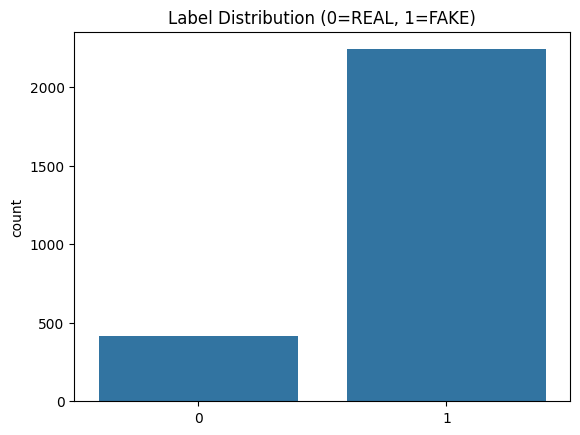

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title("Label Distribution (0=REAL, 1=FAKE)")
